CODE BLOCK: 1

<!--
>**This is Bold**
>>*This is Italics*
>>>- Simple statement
>>> - `string`
>>>> - $ mathematical symbols $
>>>> 1. Number 1
>>>> 2. Number 2


&#x25BA;


*** -->

# Session 9 - Assignment
## Basic expectations
- Architecture to C1C2C3C4O (No MaxPooling, but 3 convolutions, where the last one has a stride of 2 instead)
- Use Dilated kernels here instead of MP or strided convolution for extra points
- Total RF must be more than 44
- One of the layers must use Depthwise Separable Convolution
- One of the layers must use Dilated Convolution
- use GAP (compulsory):- add FC after GAP to target #of classes (optional)
- use albumentation library and apply:
  - horizontal flip
  - shiftScaleRotate
  - coarseDropout (max_holes = 1, max_height=16px, max_width=16, min_holes = 1, min_height=16px, min_width=16px, fill_value=(mean of your dataset), mask_fill_value = None)
- >= 85% accuracy
- As many epochs as you want
- <= 200k params

### Results:
- Epochs: 20
- Parameters: 46,000
- Training Batch size: 64
- Testing Batch size: 64
- Training
  - Loss=0.6108
  - Batch_id=781
  - Accuracy=72.16%
- Testing
  - Average loss: 0.7305
  - Accuracy: 7451/10000 (74.51%)

### To be provided
- Model code
- Torch Summary
- Albumentations code
- Training log
- README.md link


### [1. Import appropriate modules required in this file](#section-1)
- import model: importing the code written in model.py that is kept in path of current working directory
- import utils: Similarly importing code in utils.py

In [1]:
# !pip install torchsummary

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

# import utils, model

CODE BLOCK: 2

### [2. Check if GPU (CUDA) or CPU](#section-2)
- Cuda availablbility check to ensure using GPU if available for the network
- Taking the value into device variable if cuda (GPU) or only CPU

In [3]:
SEED = 1

use_cuda = torch.cuda.is_available()
print("CUDA Available?", use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")

# For reproducibility
torch.manual_seed(SEED)

if device=="cuda":
    torch.cuda.manual_seed(SEED)

CUDA Available? True


CODE BLOCK: 3

### [3. Data transforms for training and testing](#section-3)
- Transforms specific to the training and testing
- Training to include different transformations for the model to learn
- Testing not to have the same to ensure validation is on normal set

In [ ]:
# # Train data transformations
# train_transforms = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
#     transforms.RandomPerspective(distortion_scale=0.3, interpolation=3, fill=0, p=0.1),
#     transforms.Resize(32),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#     ])

# # Test data transformations
# test_transforms = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#     ])

In [4]:
class Cifar10Dataset(torchvision.datasets.CIFAR10):
    def __init__(
        self, root="../data/cifar10", train=True, download=True, transform=None
    ):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label


# class CustomDataLoader:
#     def get_train_test_transforms():
#         train_transforms = A.Compose(
#             [
#                 A.RandomCrop(32, 32, p=4),
#                 A.CoarseDropout(
#                     max_holes=1,
#                     max_height=16,
#                     max_width=16,
#                     min_holes=1,
#                     min_height=16,
#                     min_width=16,
#                     fill_value=(0.4914, 0.4822, 0.4465),
#                     always_apply=False,
#                     p=0.5,
#                 ),
#                 A.Normalize(
#                     mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)
#                 ),
#                 ToTensorV2(),
#             ]
#         )

#         # Test Phase transformations
#         test_transforms = A.Compose(
#             [
#                 A.Normalize(
#                     mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)
#                 ),
#                 ToTensorV2(),
#             ]
#         )

#         return train_transforms, test_transforms

    # def get_train_test_dataset(self):
    #     train_transforms, test_transforms = CustomDataLoader.get_train_test_transforms()
    #     train = Cifar10Dataset(
    #         root="../data", train=True, download=True, transform=train_transforms
    #     )
    #     test = Cifar10Dataset(
    #         root="../data", train=False, download=True, transform=test_transforms
    #     )

    #     return train, test

In [5]:
# horizontal flip
# shiftScaleRotate
# coarseDropout (max_holes = 1, max_height=16px, max_width=16, min_holes = 1, min_height=16px, min_width=16px, fill_value=(mean of your dataset), mask_fill_value = None)

train_transforms = A.Compose(
            [
                A.HorizontalFlip(p=0.1),
                A.ShiftScaleRotate(p=0.1),
                A.CoarseDropout(
                    max_holes=1,
                    max_height=16,
                    max_width=16,
                    min_holes=1,
                    min_height=16,
                    min_width=16,
                    fill_value=(0.5, 0.5, 0.5),
                    mask_fill_value = None,
                    p=0.1,
                ),
                A.Normalize(
                    mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)
                ),
                ToTensorV2(),
            ]
        )

# Test data transformations
test_transforms = A.Compose([
                A.Normalize(
                    mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)
                    # mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)
                ),
                ToTensorV2(),
    ])

### [4. Getting the CIFAR10 train and test dataset from torchvision datasets library](#section-4)
- Already separated datasets for train and test
- train with *50000* records and test with *10000* records
- Marking train as True of False decides the train vs test data sets
- The transforms are being loaded from utils file
- transforms being done on train but not on test

In [6]:
# train_ds = datasets.CIFAR10('../data', train=True, download=True)
# test_ds = datasets.CIFAR10('../data', train=False, download=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [7]:
train = Cifar10Dataset(root="./data", train=True, download=True, transform=train_transforms)
test = Cifar10Dataset(root="./data", train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:03<00:00, 43576232.01it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
# # We'd need to convert it into Numpy! Remember above we have converted it into tensors already
# train_data = train_ds.train_data
# train_data = train_ds.transform(train_data.numpy())

# print('[Train]')
# print(' - Numpy Shape:', train_ds.train_data.cpu().numpy().shape)
# print(' - Tensor Shape:', train_ds.train_data.size())
# print(' - min:', torch.min(train_data))
# print(' - max:', torch.max(train_data))
# print(' - mean:', torch.mean(train_data))
# print(' - std:', torch.std(train_data))
# print(' - var:', torch.var(train_data))

CODE BLOCK: 5

### [5. Data loader setup for Training and Testing](#section-5)
- Batch size definition - Keeping separate for Training and Testing
- Training lower for better training and Testing higher for faster validation
- Data loader definition

In [9]:
train_batch_size = 64
test_batch_size = 128

In [10]:
kwargs = {'shuffle': True, 'num_workers': 4, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(train, batch_size=train_batch_size, **kwargs)
test_loader = torch.utils.data.DataLoader(test, batch_size=test_batch_size, **kwargs)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


CODE BLOCK: 6

### [6. Data Visualization](#section-6)
- Visualization of data to understand the images and corresponding labels
- Also gives an understanding of the dataloader like Shuffle, etc.

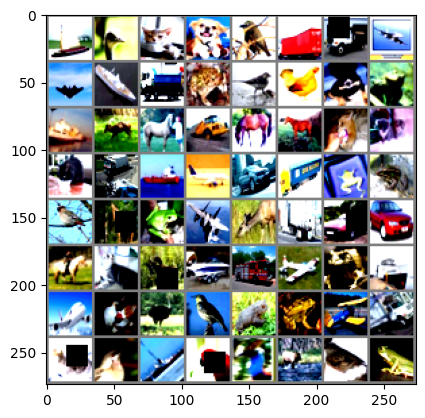

In [11]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(train_batch_size)))

CODE BLOCK: 10

### [7. Model training](#section-7)
- Loading the model on the right device - CUDA or CPU
- Setting up the right parameters like epochs, optimizer and scheduler for the training
- Running the training and validating the output against Test dataset
- While doing that also storing the loss and accuracy results for each epoch for understanding

In [12]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_accs = []
test_accs = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

ship  bird  cat   dog   bird  truck truck plane plane ship  truck frog  bird  bird  dog   frog  ship  deer  horse truck horse horse dog   cat   cat   truck ship  plane car   truck frog  frog  bird  deer  frog  plane deer  truck car   car   horse cat   deer  ship  truck plane frog  ship  plane cat   bird  bird  frog  frog  plane truck cat   bird  ship  bird  bird  deer  bird  frog 


In [33]:
# 1, 2 and 3 layers should only have dilation and stride of 2 - Try in C3 and then in C1 and C2
# 2, 3 and 4 layers should have depthwise separable convolutions - First in C4 then C3 and then C2
# GAP followed by FC or 1 x 1 layer in output
# Use Albumentations library

class ConvBlock(nn.Module):

    def __init__(self, inc, outc, dropout_value=0.1, pad=1, dilate=1, depthwise=True, last_layer=False):
        super(ConvBlock, self).__init__()

        if (depthwise):
            self.CN1 = nn.Sequential(
                nn.Conv2d(in_channels=inc,out_channels=inc,kernel_size=3,padding=pad,groups=inc,bias=False),
                nn.Conv2d(in_channels=inc,out_channels=outc,kernel_size=1,bias=False),
                nn.BatchNorm2d(outc),
                nn.ReLU(),
                nn.Dropout(dropout_value),
            )
        else:
            self.CN1 = nn.Sequential(
                nn.Conv2d(in_channels=inc,out_channels=outc,kernel_size=3,padding=pad,bias=False),
                nn.BatchNorm2d(outc),
                nn.ReLU(),
                nn.Dropout(dropout_value),
            )

        if (depthwise):
            self.CN2 = nn.Sequential(
                nn.Conv2d(in_channels=outc,out_channels=outc,kernel_size=3,padding=pad,groups=outc,bias=False),
                nn.Conv2d(in_channels=outc,out_channels=outc,kernel_size=1,bias=False),
                nn.BatchNorm2d(outc),
                nn.ReLU(),
                nn.Dropout(dropout_value),
            )
        else:
            self.CN2 = nn.Sequential(
                nn.Conv2d(in_channels=outc,out_channels=outc,kernel_size=3,padding=pad,bias=False),
                nn.BatchNorm2d(outc),
                nn.ReLU(),
                nn.Dropout(dropout_value),
            )

        if (depthwise):
            self.CN3 = nn.Sequential(
                nn.Conv2d(in_channels=outc,out_channels=outc,kernel_size=3,padding=pad,groups=outc,bias=False),
                nn.Conv2d(in_channels=outc,out_channels=outc,kernel_size=1,bias=False),
                nn.BatchNorm2d(outc),
                nn.ReLU(),
                nn.Dropout(dropout_value),
            )
        else:
            self.CN3 = nn.Sequential(
                nn.Conv2d(in_channels=outc,out_channels=outc,kernel_size=3,padding=pad,bias=False),
                nn.BatchNorm2d(outc),
                nn.ReLU(),
                nn.Dropout(dropout_value),
            )

        if (last_layer):
            if (depthwise):
                self.CNL = nn.Sequential(
                    nn.Conv2d(in_channels=outc,out_channels=outc,kernel_size=3,padding=pad,groups=outc,bias=False),
                    nn.Conv2d(in_channels=outc,out_channels=outc,kernel_size=1,bias=False),
                )
            else:
                self.CNL = nn.Sequential(
                    nn.Conv2d(in_channels=outc,out_channels=outc,kernel_size=3,padding=pad,bias=False),
                )
        else:
          if (dilate > 1):
            if (depthwise):
              self.CNL = nn.Sequential(
                  nn.Conv2d(in_channels=outc,out_channels=outc,kernel_size=3,padding=pad,dilation=2,groups=outc,bias=False),
                  nn.Conv2d(in_channels=outc,out_channels=outc,kernel_size=1,bias=False),
                  nn.BatchNorm2d(outc),
                  nn.ReLU(),
                  nn.Dropout(dropout_value),
              )
            else:
              self.CNL = nn.Sequential(
                  nn.Conv2d(in_channels=outc,out_channels=outc,kernel_size=3,padding=pad,dilation=2,bias=False),
                  nn.BatchNorm2d(outc),
                  nn.ReLU(),
                  nn.Dropout(dropout_value),
              )
          else:
            if (depthwise):
              self.CNL = nn.Sequential(
                  nn.Conv2d(in_channels=outc,out_channels=outc,kernel_size=3,padding=pad,groups=outc,bias=False),
                  nn.Conv2d(in_channels=outc,out_channels=outc,kernel_size=1,bias=False),
                  nn.BatchNorm2d(outc),
                  nn.ReLU(),
                  nn.Dropout(dropout_value),
              )
            else:
              self.CNL = nn.Sequential(
                  nn.Conv2d(in_channels=outc,out_channels=outc,kernel_size=3,padding=pad,bias=False),
                  nn.BatchNorm2d(outc),
                  nn.ReLU(),
                  nn.Dropout(dropout_value),
              )

    def forward(self, x):

        x = self.CN1(x)
        x = self.CN2(x)
        x = self.CN3(x)
        x = self.CNL(x)

        return x

class S9(nn.Module):
    def __init__(self, dropout_value):
        super(S9,self).__init__()

        self.InBlock = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=8,kernel_size=3,padding=1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(dropout_value),
        )

        self.C1 = ConvBlock(8, 16, dropout_value=dropout_value, pad=1, dilate=1, depthwise=False,  last_layer=False)
        self.C2 = ConvBlock(16, 64, dropout_value=dropout_value, pad=0, dilate=1, depthwise=True, last_layer=False)
        self.C3 = ConvBlock(64, 128, dropout_value=dropout_value, pad=0, dilate=2, depthwise=True, last_layer=False)
        self.CL = ConvBlock(128, 128, dropout_value=dropout_value, pad=0, dilate=1, depthwise=True, last_layer=True)

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6) # 7>> 9... nn.AdaptiveAvgPool((1, 1))
        )

        self.conv11 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 1
        # self.fc = nn.Linear(in_features=64,out_features=10)


    def forward(self, x):

        x = self.InBlock(x)
        x = self.C1(x)
        x = self.C2(x)
        x = self.C3(x)
        x = self.CL(x)
        x = self.gap(x)
        x = self.conv11(x)
        x = x.view(x.shape[0], -1)

        return F.log_softmax(x, dim=-1)

In [34]:
dropout_value = 0.05
mymodel = S9(dropout_value).to(device)
summary(mymodel, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             216
       BatchNorm2d-2            [-1, 8, 32, 32]              16
              ReLU-3            [-1, 8, 32, 32]               0
           Dropout-4            [-1, 8, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           1,152
       BatchNorm2d-6           [-1, 16, 32, 32]              32
              ReLU-7           [-1, 16, 32, 32]               0
           Dropout-8           [-1, 16, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]           2,304
      BatchNorm2d-10           [-1, 16, 32, 32]              32
             ReLU-11           [-1, 16, 32, 32]               0
          Dropout-12           [-1, 16, 32, 32]               0
           Conv2d-13           [-1, 16, 32, 32]           2,304
      BatchNorm2d-14           [-1, 16,

In [35]:
def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def GetIncorrectPreds(data, pPrediction, pLabels):
  images = []
  incorrectPreds = []
  nonMatchingLabels = []
  # print("pPrediction type:", type(pPrediction), "Shape:", pPrediction.shape)
  # print("pLabels type:", type(pLabels), "Shape:", pLabels.shape)
  preds = pPrediction.argmax(dim=1)
  indexes = pLabels.ne(pPrediction.argmax(dim=1))
  for image, pred, label in zip(data, preds, pLabels):
      if pred.ne(label):
          images.append(image.cpu())
          incorrectPreds.append(pred.cpu().item())
          nonMatchingLabels.append(label.cpu().item())

  # print("Incorrect Preds:", incorrectPreds, "Labels:", nonMatchingLabels)
  return images, incorrectPreds, nonMatchingLabels

def incorrectOutcomes(model, device, test_loader,reqData):
    model.eval()

    test_loss = 0
    correct = 0
    incorrectPreds = []
    nonMatchingLabels = []
    images = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            imageSet, incPred, nonMatchLabel = GetIncorrectPreds(data, output, target)
            nonMatchingLabels = nonMatchingLabels + nonMatchLabel
            incorrectPreds = incorrectPreds + incPred
            images = images + imageSet

            if len(incorrectPreds) > reqData:
              break

    return images, nonMatchingLabels, incorrectPreds

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc= 100*correct/processed
  print('\nProcessed: {}, Len TrainLoader: {}'.format(processed, len(train_loader)))
  # train_losses.append(train_loss/len(train_loader))
  train_loss = train_loss/len(train_loader)
  print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
      train_loss, correct, len(train_loader.dataset),
      100. * correct / len(train_loader.dataset)))


  return train_acc, train_loss

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc = (100. * correct / len(test_loader.dataset))
    # test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_acc, test_loss

def drawLossAccuracyPlots(train_losses, train_accs, test_losses, test_accs):
    fig, axs = plt.subplots(2,2,figsize=(15,10))
    axs[0, 0].plot(train_losses)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_accs)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_accs)
    axs[1, 1].set_title("Test Accuracy")


In [ ]:
optimizer = optim.SGD(mymodel.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.1, threshold_mode='rel', verbose=True)
criterion = F.nll_loss
num_epochs = 100

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train_acc, train_loss = train(mymodel, device, train_loader, optimizer, criterion)
  test_acc, test_loss = test(mymodel, device, test_loader, criterion)
  scheduler.step(test_loss)
  print("LR Rate:", optimizer.param_groups[0]['lr'], "\n")
  train_accs.append(train_acc)
  train_losses.append(train_loss)
  test_accs.append(test_acc)
  test_losses.append(test_loss)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1


  0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Train: Loss=1.7194 Batch_id=781 Accuracy=29.72: 100%|██████████| 782/782 [00:25<00:00, 30.22it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 1.8240, Accuracy: 14858/50000 (29.72%)


Test set: Average loss: 1.6147, Accuracy: 4036/10000 (40.36%)
LR Rate: 0.01 

Epoch 2


Train: Loss=1.6411 Batch_id=781 Accuracy=45.67: 100%|██████████| 782/782 [00:25<00:00, 30.36it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 1.4847, Accuracy: 22833/50000 (45.67%)


Test set: Average loss: 1.4126, Accuracy: 4853/10000 (48.53%)
LR Rate: 0.01 

Epoch 3


Train: Loss=1.3400 Batch_id=781 Accuracy=52.92: 100%|██████████| 782/782 [00:26<00:00, 29.60it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 1.2983, Accuracy: 26459/50000 (52.92%)


Test set: Average loss: 1.2167, Accuracy: 5633/10000 (56.33%)
LR Rate: 0.01 

Epoch 4


Train: Loss=1.4790 Batch_id=781 Accuracy=56.93: 100%|██████████| 782/782 [00:25<00:00, 30.58it/s]



Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 1.1890, Accuracy: 28463/50000 (56.93%)
Test set: Average loss: 1.0958, Accuracy: 6047/10000 (60.47%)
LR Rate: 0.01 

Epoch 5


Train: Loss=1.0317 Batch_id=781 Accuracy=60.24: 100%|██████████| 782/782 [00:25<00:00, 30.28it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 1.1083, Accuracy: 30120/50000 (60.24%)


Test set: Average loss: 0.9831, Accuracy: 6530/10000 (65.30%)
LR Rate: 0.01 

Epoch 6


Train: Loss=1.3292 Batch_id=781 Accuracy=62.43: 100%|██████████| 782/782 [00:25<00:00, 30.53it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 1.0478, Accuracy: 31216/50000 (62.43%)


Test set: Average loss: 0.9367, Accuracy: 6653/10000 (66.53%)
LR Rate: 0.01 

Epoch 7


Train: Loss=1.7489 Batch_id=781 Accuracy=64.57: 100%|██████████| 782/782 [00:25<00:00, 30.45it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.9944, Accuracy: 32284/50000 (64.57%)


Test set: Average loss: 0.8726, Accuracy: 6956/10000 (69.56%)
LR Rate: 0.01 

Epoch 8


Train: Loss=0.9737 Batch_id=781 Accuracy=66.35: 100%|██████████| 782/782 [00:25<00:00, 30.37it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.9483, Accuracy: 33174/50000 (66.35%)


Test set: Average loss: 0.8443, Accuracy: 7055/10000 (70.55%)
LR Rate: 0.01 

Epoch 9


Train: Loss=0.6277 Batch_id=781 Accuracy=67.77: 100%|██████████| 782/782 [00:25<00:00, 30.36it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.9105, Accuracy: 33884/50000 (67.77%)


Test set: Average loss: 0.8637, Accuracy: 7052/10000 (70.52%)
LR Rate: 0.01 

Epoch 10


Train: Loss=0.5592 Batch_id=781 Accuracy=68.82: 100%|██████████| 782/782 [00:26<00:00, 29.94it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.8756, Accuracy: 34410/50000 (68.82%)


Test set: Average loss: 0.7934, Accuracy: 7260/10000 (72.60%)
LR Rate: 0.01 

Epoch 11


Train: Loss=0.5972 Batch_id=781 Accuracy=70.02: 100%|██████████| 782/782 [00:25<00:00, 30.27it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.8459, Accuracy: 35012/50000 (70.02%)


Test set: Average loss: 0.7935, Accuracy: 7153/10000 (71.53%)
LR Rate: 0.01 

Epoch 12


Train: Loss=1.4630 Batch_id=781 Accuracy=71.22: 100%|██████████| 782/782 [00:25<00:00, 30.49it/s]



Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.8222, Accuracy: 35609/50000 (71.22%)
Test set: Average loss: 0.7535, Accuracy: 7434/10000 (74.34%)
LR Rate: 0.01 

Epoch 13


Train: Loss=0.8387 Batch_id=210 Accuracy=71.70:  27%|██▋       | 211/782 [00:07<00:21, 26.11it/s]

CODE BLOCK: 11

### [8. Model Accuracy and Loss plots visualization](#section-8)
- Part of utils
- Drawing plots of Training and Testing accuracy and loss
- This gives us an understanding of how the accuracy and losses improved over epochs
- Also helps to understand where we should have stopped the training for optimum results

In [ ]:
# utils.drawLossAccuracyPlots(train_losses, train_accs, test_losses, test_accs)

In [ ]:
# reqData = 10
# images, nonMatchingLabels, incorrectPreds = utils.incorrectOutcomes(mymodel, device, test_loader, reqData)

In [ ]:
# plt.figure(figsize=(10,10))
# plt.tight_layout()

# right = 0
# mistake = 0

# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     return np.transpose(npimg, (1, 2, 0))

# for i in range(reqData):
#     image = images[i]
#     pred = classes[incorrectPreds[i]]
#     gt = classes[nonMatchingLabels[i]]

#     plt.subplot(2,int(reqData/2),i+1)
#     plt.imshow(imshow(image))
#     plt.axis('on')

#     # ret = model.predict(data, batch_size=1)
#     #print(ret)

#     plt.title("Pred:" + pred + "\nGT:" + gt, color='#ff0000', fontdict={'fontsize': 12})

# plt.show()